In [1]:
import pydicom
import os,re
import numpy as np
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from pydicom.dataset import Dataset, FileDataset
import tempfile
import SimpleITK as sitk
import math
from ipywidgets import interact, fixed
from skimage.transform import resize
from IPython.display import clear_output
from scipy.ndimage import zoom
import scipy.misc
from sys import platform
import shutil

from MyProcessDicom import *
from RegistrationMethod import *
from ServerDicomIO import *
from icafeAPI import generate_centerline
platform

'win32'

In [2]:
import importlib
import sys
sys.path.append(r'..\FRAPPE')
import DB
importlib.reload(DB)
from DB import DB

# process list
# first in TP as reference
caselist = [
    {'pid': '9404954','TP':[0,1,2,3,4,5,6,8,10],'side':'L'}
]

# getdcmpath('9911265',0,'L'),getdcmpath('9911265',1,'R'),getdcmpath('9911265',8,'R')

In [3]:
# #split seqs for a case
# getFileFromDB(caselist)

In [35]:
casei = caselist[0]
pi = casei['pid']
side = casei['side']
precasepath = split_seq_path + pi + side + '/'
regtp = casei['TP']
if len(regtp) < 2:
    print(pi, 'not enough TPs')
tp1 = regtp[0]
print("Fixed Image %d" % tp1)
tp1_casepath = precasepath + 'TP0/'
fixed_image = get_dicom_series(tp1_casepath)

icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
if not os.path.exists(icafesavepath):
    print('Init icafe dir')
    os.mkdir(icafesavepath)

Fixed Image 0


In [36]:
isoresample = sitk.ResampleImageFilter()
isoresample.SetInterpolator(sitk.sitkBSpline)
isoresample.SetOutputDirection(fixed_image.GetDirection())
isoresample.SetOutputOrigin(fixed_image.GetOrigin())
orig_spacing = fixed_image.GetSpacing()
new_spacing = (orig_spacing[0],orig_spacing[0],orig_spacing[0])
isoresample.SetOutputSpacing(new_spacing)
orig_size = np.array(fixed_image.GetSize(), dtype=np.int)    
new_size = orig_size.copy()
new_size[2] = int(orig_size[2]*(orig_spacing[2]/orig_spacing[0])+0.5)
new_size = [int(s) for s in new_size]
print(orig_size, new_size)
isoresample.SetSize(new_size)

[384 384  75] [384, 384, 309]


In [37]:
img1 = empty_preprocess(fixed_image)

In [22]:
img1.GetSize()

(384, 384, 75)

In [38]:
img2 = isoresample.Execute(img1)

In [39]:
show_images(img2, img2)

interactive(children=(IntSlider(value=154, description='fixed_image_z', max=308), IntSlider(value=154, descrip…

In [17]:
def do_registration(casei, regis_fun):
    pi = casei['pid']
    side = casei['side']
    precasepath = split_seq_path + pi + side + '/'
    regtp = casei['TP']
    if len(regtp) < 2:
        print(pi, 'not enough TPs')
        return
    tp1 = regtp[0]
    print("Fixed Image %d" % tp1)
    tp1_casepath = precasepath + 'TP0/'
    fixed_image = get_dicom_series(tp1_casepath)
    
    icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
    if not os.path.exists(icafesavepath):
        print('Init icafe dir')
        os.mkdir(icafesavepath)
    
    # isotropic resolution
    img1 = resample_image(fixed_image)
    sitk.WriteImage(sitk.Cast(img1, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
    sitk.WriteImage(sitk.Cast(img1, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_US100.tif')
    print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_US100.tif')
    
    fixed_image = preprocess(fixed_image)
    fixed_ret, resampled_ret = [], []
    for tp2 in regtp[7:8]:
        #if tp2 != 1: continue
        print("************************************************")
        print("Processing %d......" % tp2)
        tp2_casepath = getdcmpath(pi,tp2,side)
        if tp2_casepath is None:
            print('cannot find dcm path for TPid', tp2)
            continue
        
        tp2_casepath = precasepath + 'TP' + str(tp2) + '/'
        print("reading image......", pi + 'TP' + str(tp2))
        moving_image = get_dicom_series(tp2_casepath)
        moving_image = preprocess(moving_image)
        show_images(fixed_image, moving_image)
        
        transform = regis_fun(fixed_image, moving_image)
        if tp2==10:
            SEQ = 'S109'
        else:
            SEQ = 'S10'+str(tp2)
        sitk.WriteTransform(transform, transform_path + 'P'+  pi + side + 'U' + SEQ + '.tfm')
        tmp_img = transform_img(fixed_image, moving_image, transform)

#         sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_U' + SEQ + '.tif')
#         print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U' + SEQ + '.tif')
        fixed_ret.append(fixed_image)
        resampled_ret.append(tmp_img)
    return fixed_ret, resampled_ret

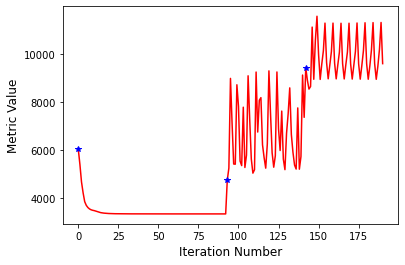

Final metric value: 8939.19121360552
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 49.


In [18]:
for casei in caselist:
    ret = do_registration(casei, affine_registration)
    fixed_ret, resampled_ret = ret
#     if ret is not None:
#         fixed_image, moving_resampled = ret
#         interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), 
#                  fixed = fixed(fixed_image), moving=fixed(moving_resampled));

In [19]:
show_mixed_images(fixed_ret[0], resampled_ret[0])

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [5]:
for case in caselist:
    pid = case['pid']
    side = case['side']
    for j in range(len(case['TP'])):
        generate_centerline(pid, case['TP'][j], side)

ahaknee0tp29  exist
ahaknee12tp29  exist
ahaknee18tp29  exist
ahaknee24tp29  exist
ahaknee30tp29  exist
ahaknee36tp29  exist
ahaknee48tp29  exist
ahaknee72tp29  exist
ahaknee96tp29  exist


In [8]:
def get_centerline(pid, TPid, side='L'):
    dir_path = r'../centerline/P'+pid+side
    file_path = dir_path+'/tracing_raw_ves_TH_'+str(TPid)+'_P'+pid+side+'_U.swc'
    df = pd.read_csv(file_path, header=None, sep=' ',index_col=0, names=['vessel_id','x','y','z','undefined','last_id'])
    line = np.array([df['x'], df['y'], df['z']]).T
    return df, line

In [9]:
case = caselist[0]
df1, line1 = get_centerline(case['pid'], case['TP'][0], case['side'])
df1.head(20)
df2, line2 = get_centerline(case['pid'], case['TP'][1], case['side'])
df2.head(20)

,vessel_id,x,y,z,undefined,last_id
1,0,217.0,305.0,4.11,8.29,0
2,0,216.0,305.0,8.23,8.76,1
3,0,215.0,305.0,12.34,8.79,2
4,0,213.0,305.0,16.46,9.20,3
5,0,212.0,305.0,20.57,9.10,4
6,0,211.0,305.0,24.69,9.15,5
7,0,211.0,305.0,28.80,9.08,6
8,0,210.0,305.0,32.91,9.15,7
9,0,208.0,306.0,37.03,9.18,8
10,0,207.0,306.0,41.14,9.30,9


In [10]:
regtp = case['TP']
tp2 = regtp[1]
if tp2==10:
    SEQ = 'S109'
else:
    SEQ = 'S10'+str(tp2)
affine = sitk.ReadTransform(transform_path + 'P'+  case['pid'] + case['side'] + 'U' + SEQ + '.tfm')

In [11]:
points = []
for i in range(line1.shape[0]):
    tmp_point = affine.TransformPoint((line1[i][0], line1[i][1], i))
    points.append(tmp_point)
ans = np.array(points)
ans[:,2] = np.round(ans[:,2])

In [12]:
dx, dy = [], []
for i in range(ans.shape[0]):
    if int(ans[i][2]) >= 75:
        break
    dx.append(ans[i][0] - line2[int(ans[i][2])][0])
    dy.append(ans[i][1] - line2[int(ans[i][2])][1])
dx = np.array(dx)
dy = np.array(dy)

In [13]:
displacement_image = sitk.Image([384,384,dx.shape[0]], sitk.sitkVectorFloat64)
# The only point that has any displacement is (0,0)
for i in range(dx.shape[0]):
    displacement = (-dx[i],-dy[i],0)
    for j in range(384):
        for k in range(384):
            displacement_image[j,k,i] = displacement

displacement_field_transform = sitk.DisplacementFieldTransform(displacement_image)

In [14]:
pi = case['pid']
side = case['side']
precasepath = split_seq_path + pi + side + '/'
regtp = case['TP']
tp1, tp2 = regtp[0], regtp[1]
tp1_casepath = precasepath + 'TP0/'
fixed_image = get_dicom_series(tp1_casepath)

icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
tp2_casepath = precasepath + 'TP' + str(tp2) + '/'

moving_image = get_dicom_series(tp2_casepath)
fixed_image = empty_preprocess(fixed_image)
moving_image = empty_preprocess(moving_image)

In [15]:
resampled = transform_img(fixed_image, moving_image, affine)
show_mixed_images(fixed_image, resampled)

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [16]:
resampled2 = transform_img(fixed_image, resampled, displacement_field_transform)
show_mixed_images(fixed_image, resampled2)

interactive(children=(IntSlider(value=37, description='image_z', max=74), FloatSlider(value=0.5, description='…

In [28]:
# def our_pipeline(casei):
#     pi = casei['pid']
#     side = casei['side']
#     precasepath = split_seq_path + pi + side + '/'
#     regtp = casei['TP']
#     if len(regtp) < 2:
#         print(pi, 'not enough TPs')
#         return
#     tp1 = regtp[0]
#     print("Fixed Image %d" % tp1)
#     tp1_casepath = precasepath + 'TP0/'
#     fixed_image = get_dicom_series(tp1_casepath)
    
#     icafesavepath = icafepath+'0_P'+pi+side+'_U'+'/'
#     if not os.path.exists(icafesavepath):
#         print('Init icafe dir')
#         os.mkdir(icafesavepath)
    
#     # isotropic resolution
    
#     fixed_image = resample_image(fixed_image)
#     img1 = fixed_image
#     sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
#     print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U.tif')
#     sitk.WriteImage(sitk.Cast(fixed_image, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_US100.tif')
#     print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_US100.tif')
    
# #     fixed_image = img1
#     fixed_image = preprocess(img1)
#     fixed_ret, resampled_ret = [], []
#     for tp2 in regtp[1:3]:
#         #if tp2 != 1: continue
#         print("************************************************")
#         print("Processing %d..." % tp2)
#         tp2_casepath = getdcmpath(pi,tp2,side) 
#         if tp2_casepath is None:
#             print('cannot find dcm path for TPid', tp2)
#             continue
        
#         tp2_casepath = precasepath + 'TP' + str(tp2) + '/'
#         print("reading image......", pi + 'TP' + str(tp2))
#         moving_image = get_dicom_series(tp2_casepath)
#         img2 = resample_image(moving_image)
#         moving_image = preprocess(img2)
        
#         if tp2 <=8:
#             transform = rigid_registration(fixed_image, moving_image, vis=False)
#             img2 = sitk.Resample(empty_preprocess(img2), empty_preprocess(img1), transform, sitk.sitkBSpline, 0.0, empty_preprocess(img2).GetPixelID())
#             moving_image = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkBSpline, 0.0, moving_image.GetPixelID())
        
#         ffd_transform = bspline_intra_modal_registration(fixed_image, moving_image, vis=False)
#         exqimg = sitk.Resample(empty_preprocess(img2), empty_preprocess(img1), ffd_transform, sitk.sitkBSpline, 0.0, empty_preprocess(img2).GetPixelID())
#         tmp_img = exqimg
        
#         if tp2==10:
#             SEQ = 'S109'
#         else:
#             SEQ = 'S10'+str(tp2)
# #         exqimg = resample_image(exqimg)
#         sitk.WriteImage(sitk.Cast(exqimg, sitk.sitkInt16), icafesavepath + 'TH_0_P'+  pi + side + '_U' + SEQ + '.tif')
#         print('save to icafe path', icafesavepath + 'TH_0_P' + pi + side + '_U' + SEQ + '.tif')
#         fixed_ret.append(empty_preprocess(img1))
#         resampled_ret.append(empty_preprocess(tmp_img))
#     return fixed_ret, resampled_ret

In [28]:
# for casei in caselist:
#     our_pipeline(casei)